The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
--- Loaded Configuration ---
{
  "telescope_name": "DSA-110",
  "instrument_type": "Multi-Dish Interferometer",
  "native_channel_width_mhz": 0.03051757812,
  "total_bandwidth_mhz": 187.5,
  "num_channels": 6144,
  "min_freq_mhz": 1311.25,
  "max_freq_mhz": 1498.75,
  "burst_id": "casey",
  "input_data_path": "/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/data/casey.npz",
  "telescope": "dsa",
  "analysis": {
    "rfi_masking": {
      "find_burst_thres": 5.0,
      "padding_factor": 0.0,
      "use_symmetric_noise_window": true,
      "rfi_downsample_factor": 16,
      "enable_time_domain_flagging": false,
      "time_threshold_sigma": 7.0,
      "freq_threshold_sigma": 5.0
    },
    "acf": {
      "num_subbands": 2,
      "max_lag_mhz": 45.0,
      "use_snr_subbanding": false,
      "enable_intra_pulse_analysis": true,
      "intra_pulse_time_bins": 5
    },
  

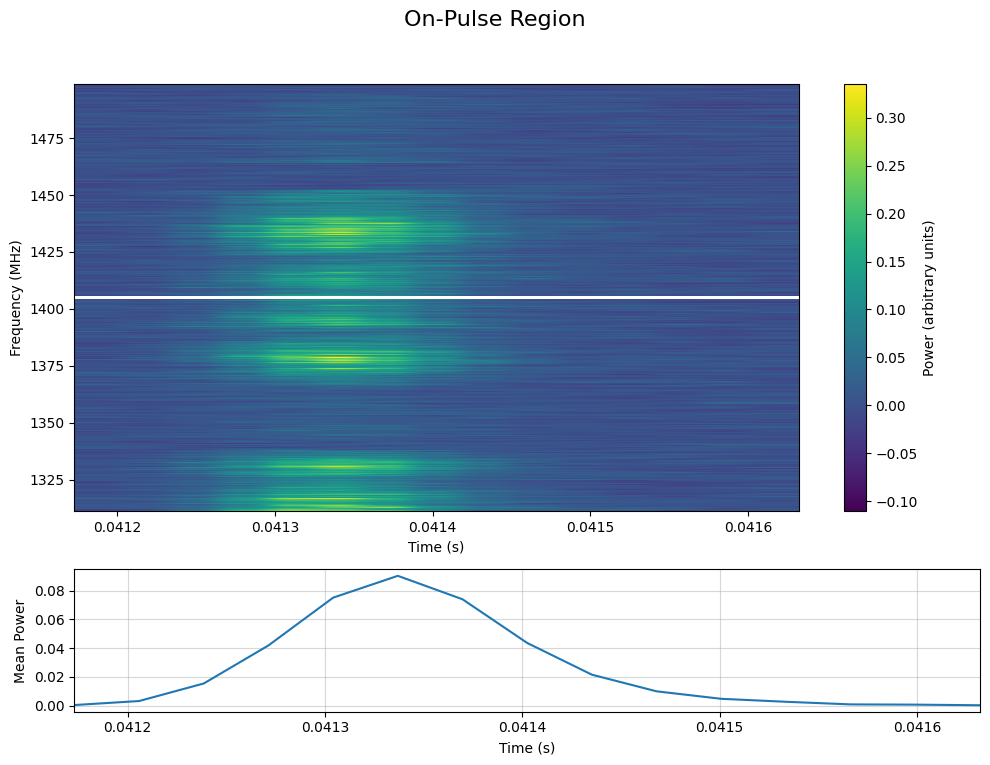

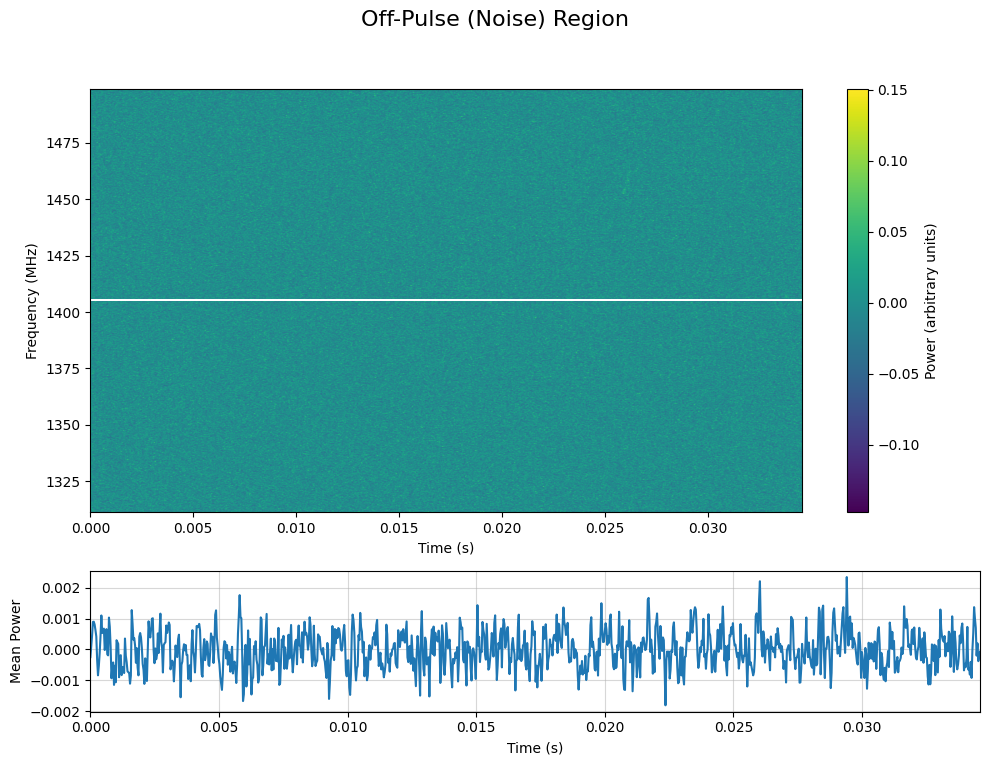

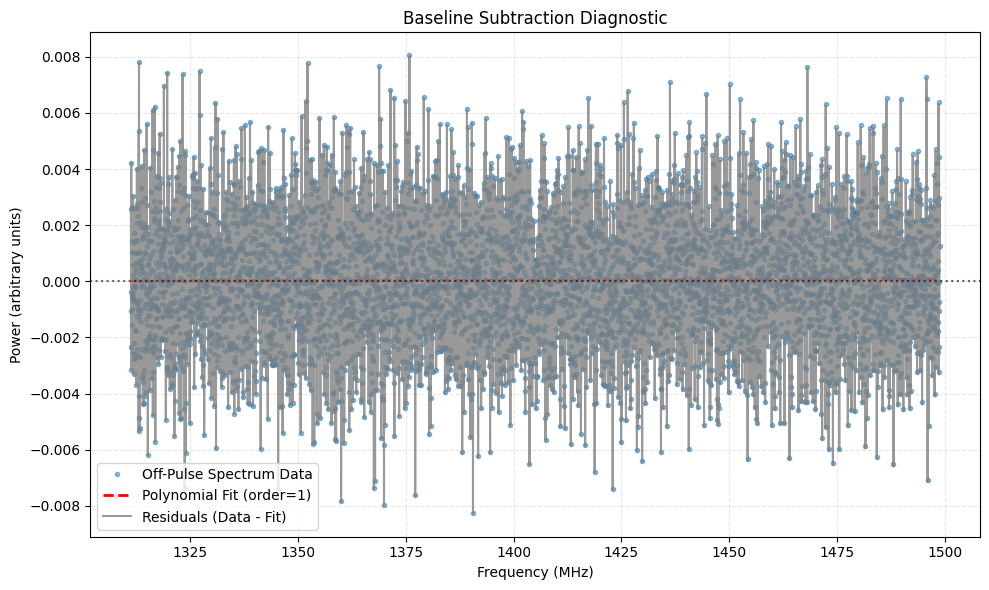

/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/scint_analysis/noise.py:145: UserWarning: NaNs detected – in‑painting with row/col medians.
  warnings.warn("NaNs detected – in‑painting with row/col medians.")
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


--- Pipeline Execution Finished ---


In [10]:
# Set path for module imports
import sys
# replace the path below with the absolute path to your `scattering/` folder
pkg_root = "/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation"
sys.path.insert(0, pkg_root)

%load_ext autoreload
%autoreload 2

# Run this cell to import necessary libraries
import json
import pickle
import logging
import numpy as np
import matplotlib.pyplot as plt

# --- Bokeh Imports for Jupyter (Corrected) ---
from bokeh.io import output_notebook, show
from bokeh.layouts import row, column
from bokeh.models import ColumnDataSource, Slider, Div
from bokeh.plotting import figure

# --- Your Pipeline's Imports ---
# Make sure your scint_analysis package is importable
# (You may need to add its path using sys.path.insert)
try:
    from scint_analysis import config, pipeline, plotting
    from scint_analysis.analysis import lorentzian_model_3_comp
    from scint_analysis.core import ACF
except ImportError as e:
    logging.error(f"Could not import scint_analysis. Make sure it's in your Python path. {e}")

# --- 1. Configuration ---
# Set up basic logging to see pipeline output in the notebook
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Define the path to the configuration file for the analysis run
BURST_CONFIG_PATH = '/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/casey_dsa.yaml'

# Load the merged configuration from the YAML files
try:
    analysis_config = config.load_config(BURST_CONFIG_PATH)
    print("--- Loaded Configuration ---")
    print(json.dumps(analysis_config, indent=2))
except Exception as e:
    logging.error(f"Failed to load configuration: {e}")
    # Stop execution if config fails
    raise

# --- 2. Initialize and Run the Pipeline ---
print("\n--- Initializing and Running Scintillation Pipeline ---")
# Create an instance of the main pipeline controller
scint_pipeline = pipeline.ScintillationAnalysis(analysis_config)

# This single .run() call executes all the steps in the correct order:
# - Loads and masks data
# - Characterizes off-pulse noise (NEW)
# - Calculates ACFs using the noise model for normalization
scint_pipeline.run()
print("--- Pipeline Execution Finished ---")

In [7]:
# Run this cell to load the data for one sub-band
SUBBAND_INDEX = 0 # Choose which sub-band to analyze (0, 1, 2...)
ACF_RESULTS_PATH = '/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/data/cache/casey/casey_acf_results.pkl' # Adjust path if needed

try:
    with open(ACF_RESULTS_PATH, 'rb') as f:
        acf_results = pickle.load(f)
    logging.info(f"Successfully loaded ACF results from {ACF_RESULTS_PATH}")
except FileNotFoundError:
    logging.error(f"ERROR: ACF results file not found at {ACF_RESULTS_PATH}. Please run the main pipeline first.")
    
# Create a clean ACF object for the selected sub-band
lags = acf_results['subband_lags_mhz'][SUBBAND_INDEX]
data = acf_results['subband_acfs'][SUBBAND_INDEX]
# Use the robustly calculated errors for chi-squared calculation
errors = np.sqrt(acf_results['subband_acfs_err'][SUBBAND_INDEX]**2) if 'subband_acfs_err' in acf_results else np.ones_like(data)

acf_obj = ACF(acf_data=data, lags_mhz=lags, acf_err=errors)

In [8]:
# Run this cell to define the application logic
def make_document(doc):
    """
    This function is a self-contained Bokeh application.
    It takes a Bokeh document `doc` and adds the interactive plot to it.
    """
    # --- Define Model and Parameters for Sliders ---
    model_func = lorentzian_model_3_comp
    param_names = ['gamma1', 'm1', 'gamma2', 'm2', 'gamma3', 'm3', 'c3']
    
    # Use initial guesses from your pipeline config as the starting point
    p0 =           [0.05,  0.5,  0.2,   0.4,  0.8,   0.3,  0.0] 
    lower_bounds = [1e-4,  0,    1e-4,  0,    1e-4,  0,    -0.2]
    upper_bounds = [1.0,   1.5,  2.0,   1.5,  5.0,   1.5,  0.2]

    # --- Prepare Data Sources ---
    x_lags = acf_obj.lags
    y_data = acf_obj.acf
    y_model_init = model_func(x_lags, *p0)

    source_data = ColumnDataSource(data=dict(x=x_lags, y=y_data))
    source_model = ColumnDataSource(data=dict(x=x_lags, y=y_model_init))
    source_resid = ColumnDataSource(data=dict(x=x_lags, y=(y_data - y_model_init)))

    # --- Set up Plots ---
    plot = figure(height=400, width=700, title=f"Interactive ACF Fit (Sub-band {SUBBAND_INDEX})", x_axis_label="Frequency Lag (MHz)")
    plot.circle('x', 'y', source=source_data, legend_label="ACF Data", color="navy", alpha=0.6)
    plot.line('x', 'y', source=source_model, legend_label="Interactive Model", color="crimson", line_width=2)
    plot.legend.location = "top_right"

    plot_residual = figure(height=200, width=700, title="Residuals", x_range=plot.x_range, x_axis_label="Frequency Lag (MHz)")
    plot_residual.line('x', 'y', source=source_resid, line_color="black")
    plot_residual.line(x_lags, np.zeros_like(x_lags), line_dash='dashed', color='gray')

    # --- Set up Widgets ---
    sliders = [Slider(title=name, value=val, start=low, end=high, step=(high-low)/200)
               for name, val, low, high in zip(param_names, p0, lower_bounds, upper_bounds)]
    gof_div = Div(text="Reduced Chi-Squared: N/A", width=300, style={'font-size': '1.1em', 'font-weight': 'bold'})

    # --- Define the Callback Function ---
    def update_fit(attr, old, new):
        p = [s.value for s in sliders]
        new_y_model = model_func(x_lags, *p)
        source_model.data['y'] = new_y_model
        
        new_resid = source_data.data['y'] - new_y_model
        source_resid.data['y'] = new_resid
        
        err = np.maximum(acf_obj.err, 1e-9)
        chisqr = np.sum((new_resid / err)**2)
        dof = len(y_data) - len(p)
        if dof > 0:
            redchi = chisqr / dof
            gof_div.text = f"<b>Reduced Chi-Squared: {redchi:.3f}</b>"

    for w in sliders:
        w.on_change('value', update_fit)
        
    # Trigger the initial GoF calculation
    update_fit(None, None, None)

    # --- Assemble Layout and Add to Document ---
    inputs = column(sliders)
    plots = column(plot, plot_residual)
    layout = row(inputs, plots, gof_div)
    
    doc.add_root(layout)
    doc.title = "ACF Explorer"

In [9]:
# Run this cell to display the interactive plot below

# This tells Bokeh to generate output in the notebook
output_notebook()

# This runs make_document as an application and embeds it
show(make_document)

Loading BokehJS ...

-------------------------------------------------------------------------------

INFO: Loading burst configuration from: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/casey_dsa.yaml
INFO: Loading telescope configuration from: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/../telescopes/dsa.yaml
INFO: Configurations successfully loaded and merged.
INFO: --- Starting Scintillation Pipeline for casey ---
INFO: Noise modelling disabled by config.
INFO: Loading and processing raw data...
INFO: Loading DynamicSpectrum from file: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/data/casey.npz
INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 2500)
INFO: Applying RFI masking.
INFO: Using time downsampling factor of 16 for RFI statistical checks.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
--- Loaded Configuration ---
{
  "telescope_name": "DSA-110",
  "instrument_type": "Multi-Dish Interferometer",
  "native_channel_width_mhz": 0.03051757812,
  "total_bandwidth_mhz": 187.5,
  "num_channels": 6144,
  "min_freq_mhz": 1311.25,
  "max_freq_mhz": 1498.75,
  "burst_id": "casey",
  "input_data_path": "/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/data/casey.npz",
  "telescope": "dsa",
  "analysis": {
    "rfi_masking": {
      "find_burst_thres": 5.0,
      "padding_factor": 0.0,
      "use_symmetric_noise_window": true,
      "rfi_downsample_factor": 16,
      "enable_time_domain_flagging": false,
      "time_threshold_sigma": 7.0,
      "freq_threshold_sigma": 5.0
    },
    "acf": {
      "num_subbands": 2,
      "max_lag_mhz": 45.0,
      "use_snr_subbanding": false,
      "enable_intra_pulse_analysis": true,
      "intra_pulse_time_bins": 5
    },
  

INFO: Finding full signal envelope with S/N threshold > 5.0 (downsample ×8).
INFO: Full signal envelope found between bins 1256 and 1271.
INFO: Using symmetric noise window of duration 15 bins.
INFO: Using downsampled noise statistics from bins 77 to 78.
Iterative RFI Masking in Frequency Domain: 100%|██████████| 5/5 [00:00<00:00, 740.83it/s]
INFO: Masked 0 channels based on frequency-domain stats.
INFO: Skipping time-domain RFI flagging as per configuration.
INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 2500)
INFO: Applying polynomial baseline subtraction...
INFO: Finding full signal envelope with S/N threshold > 5.0 (downsample ×8).
INFO: Full signal envelope found between bins 1256 and 1271.
INFO: Performing order-1 polynomial baseline subtraction using off-pulse spectrum.
INFO: Baseline subtraction complete.
INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 2500)
INFO: Locating burst and defining analysis windows...
INFO: Finding full

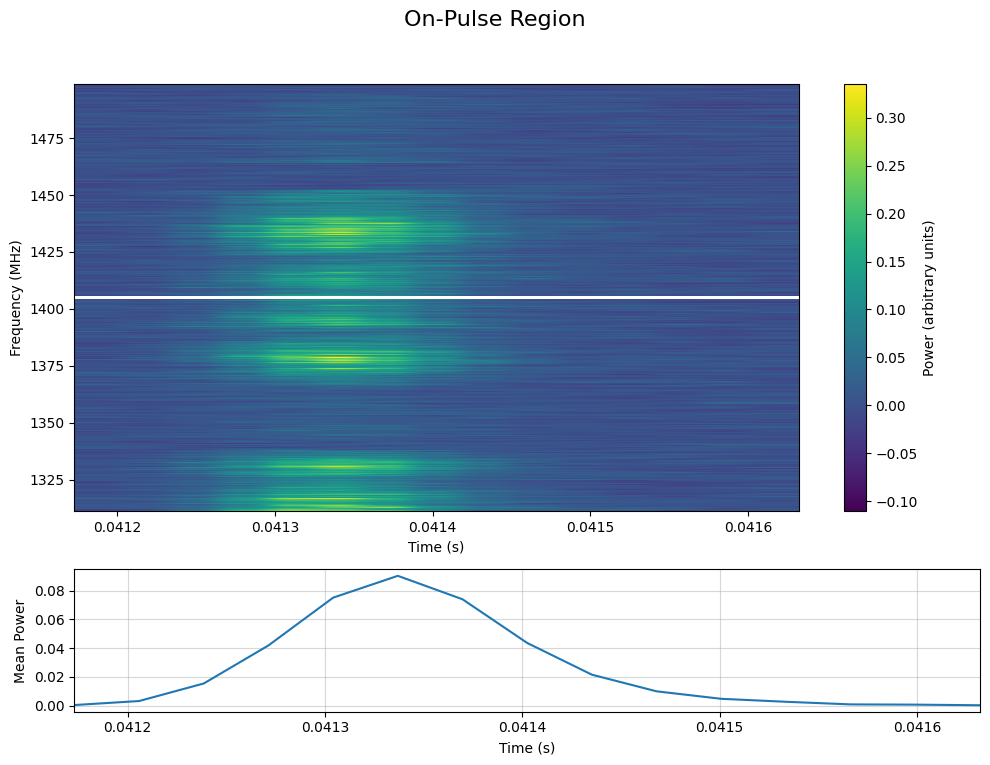

INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 1056)
INFO: Generating diagnostic plot: Off-Pulse (Noise) Region
INFO: Diagnostic plot saved to: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics/casey_off_pulse_diagnostic.png


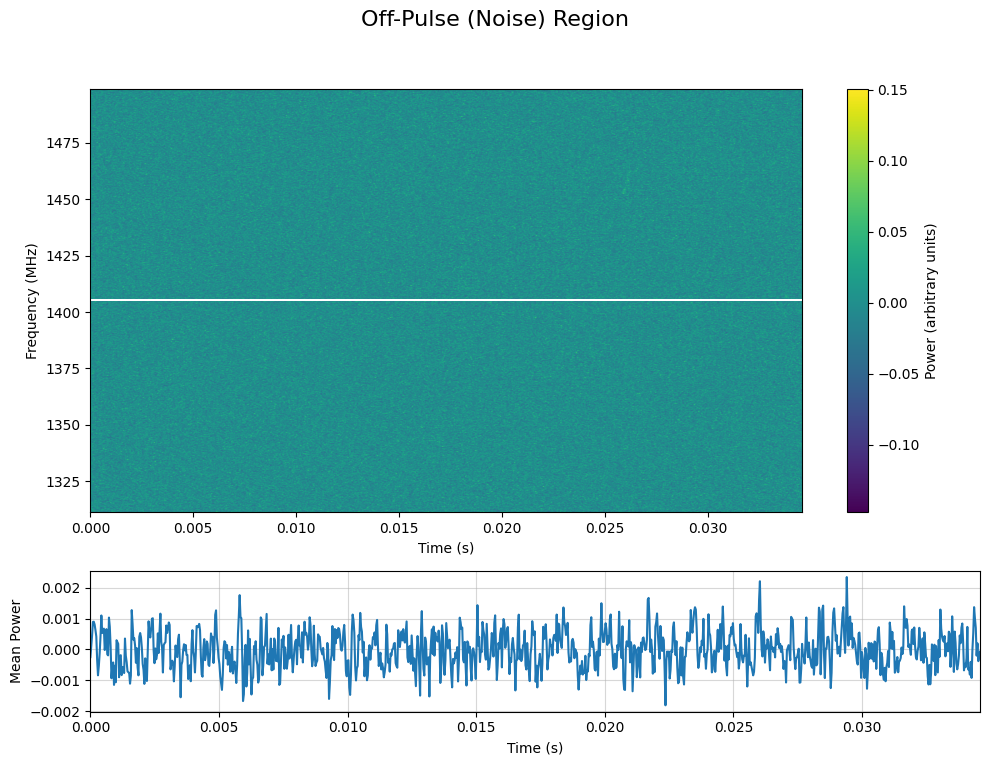

INFO: On/Off pulse diagnostic plots saved to: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics
INFO: Generating baseline fit diagnostic plot.
INFO: Generating baseline fit diagnostic plot.
INFO: Baseline diagnostic plot saved to: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics/casey_baseline_diagnostic.png


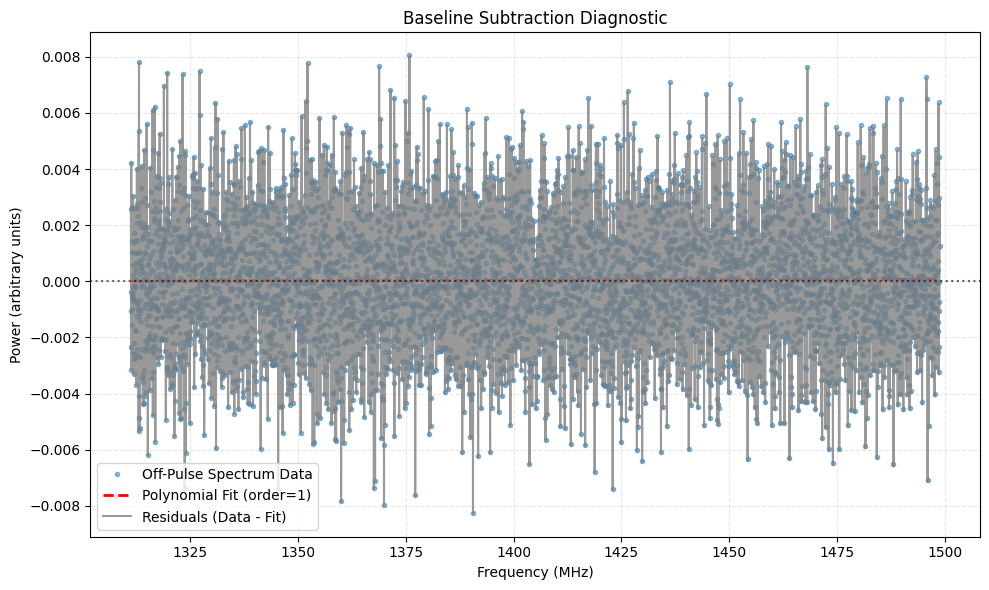

INFO: Characterizing off-pulse noise...
/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/scint_analysis/noise.py:145: UserWarning: NaNs detected – in‑painting with row/col medians.
  warnings.warn("NaNs detected – in‑painting with row/col medians.")
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
INFO: Noise characterization complete. Detected kind: 'flux_shiftedgamma'
INFO: Calculating ACFs for all sub-bands...
INFO: Starting sub‑band ACF calculations (self‑noise + synthetic‑noise aware).
ACF per sub‑band: 100%|██████████| 2/2 [00:00<00:00, 18.96it/s]
INFO: Running intra-pulse analysis...
INFO: Starting intra-pulse scintillation analysis...
Analyzing ACF vs. Time:   0%|          | 0/5 [00:00<?, ?it/s]/opt/pysetup/.venv/lib/python3.8/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects wit

--- Pipeline Execution Finished ---

--- Saving results to ./casey_analysis_results.json ---


INFO: Final results saved to ./casey_analysis_results.json
INFO: Finding full signal envelope with S/N threshold > 5.0 (downsample ×8).
INFO: Full signal envelope found between bins 1256 and 1271.
INFO: Generating intra-pulse evolution plot with 2D ACF heatmap.
/opt/pysetup/.venv/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)



--- Generating Intra-Pulse Evolution Plot ---


INFO: Intra-pulse evolution plot saved to: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics/casey_intra_pulse_evolution.png


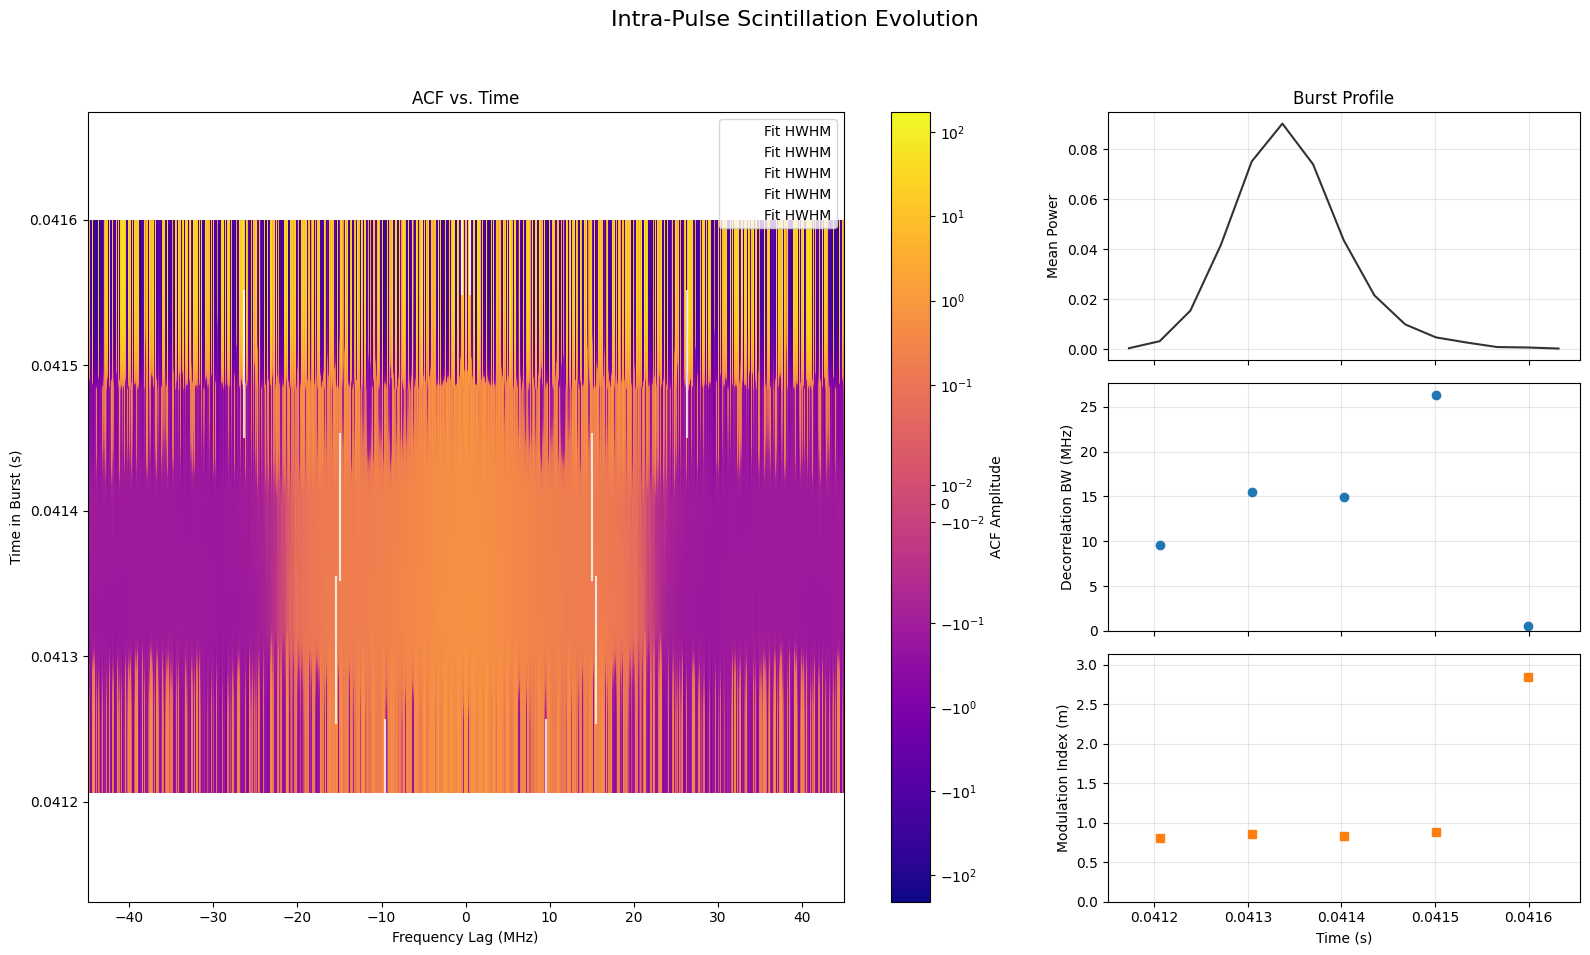

INFO: Generating full analysis overview plot.



--- Generating Final Analysis Plot ---
Saved plots to: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/plots/casey_analysis_overview.png


INFO: Analysis overview plot saved to: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/plots/casey_analysis_overview.png


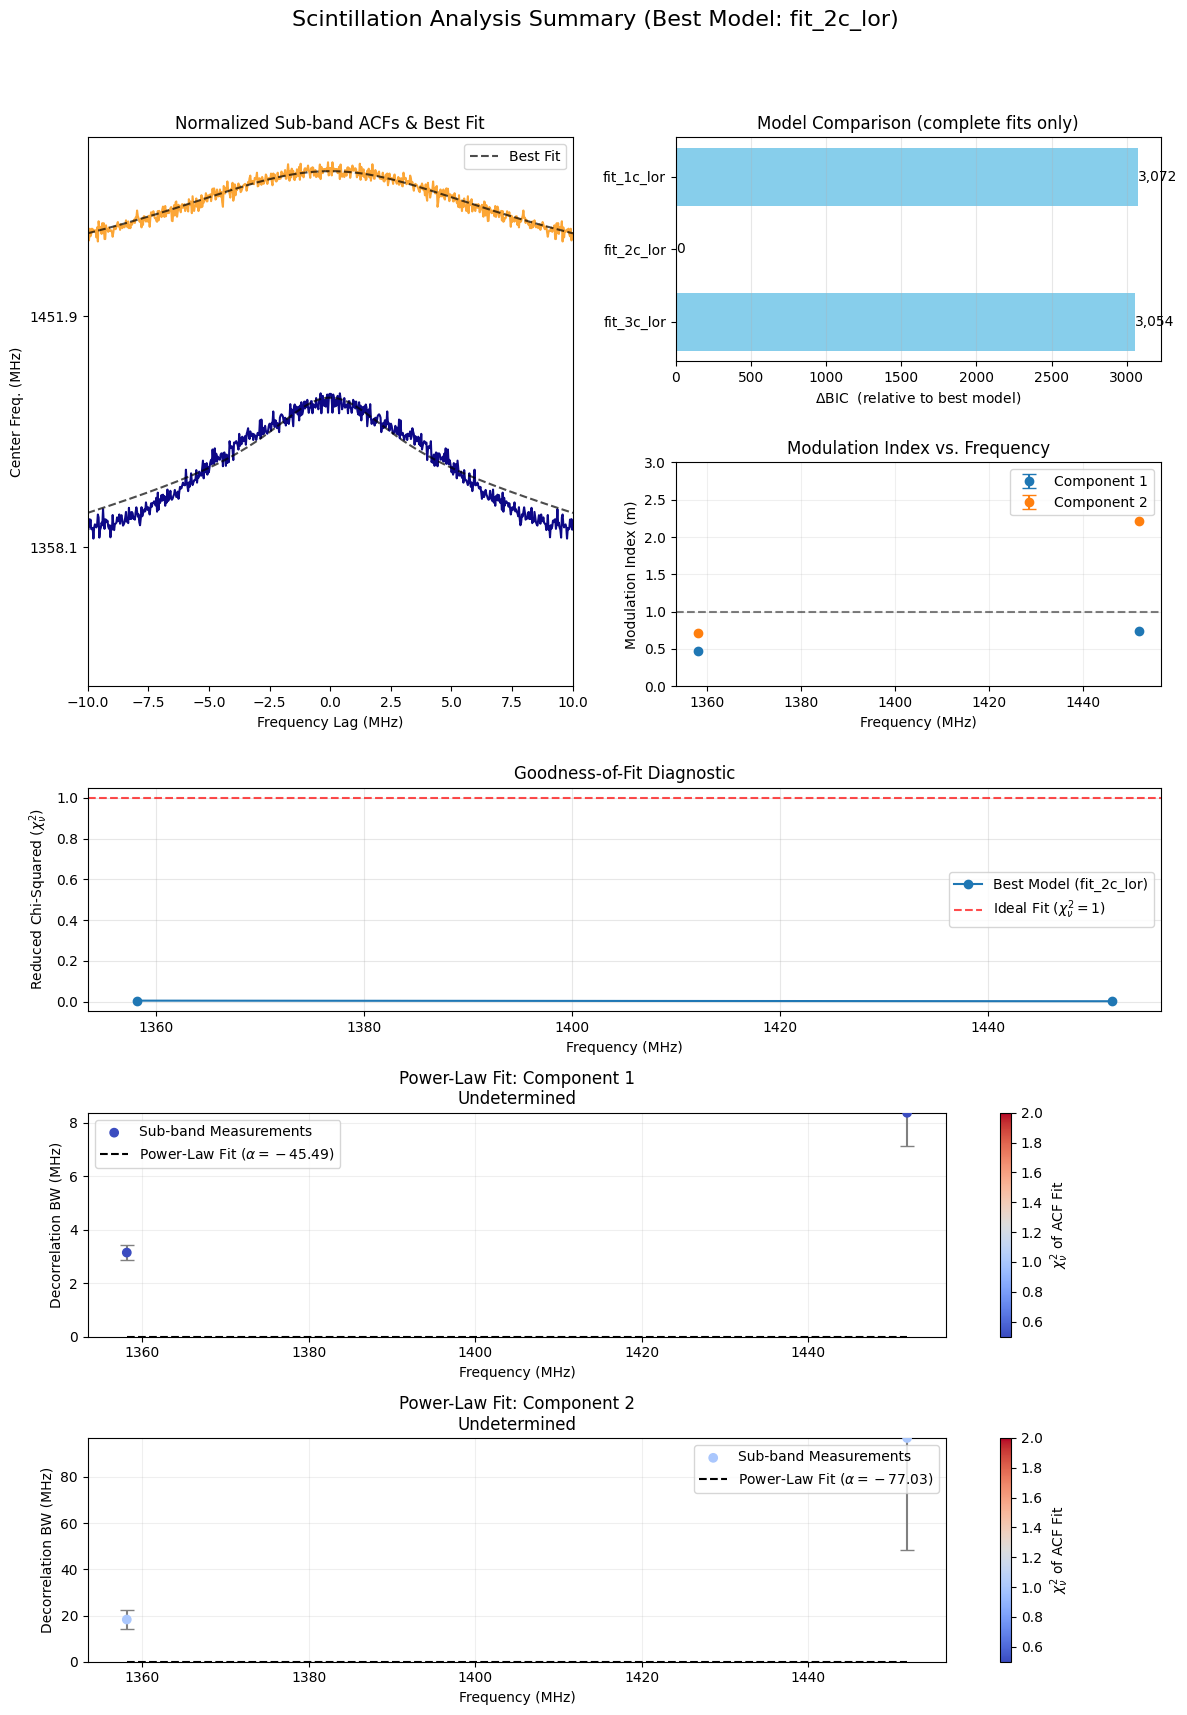

In [12]:
# Set path for module imports
import sys
# replace the path below with the absolute path to your `scattering/` folder
pkg_root = "/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation"
sys.path.insert(0, pkg_root)

%load_ext autoreload
%autoreload 2

import json
import logging
import numpy as np
import matplotlib.pyplot as plt


# Import the main pipeline components
from scint_analysis import config, pipeline, plotting
# Import your new noise model if you need to use it separately
# from scint_analysis import noise_model 

# --- 1. Configuration ---
# Set up basic logging to see pipeline output in the notebook
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Define the path to the configuration file for the analysis run
BURST_CONFIG_PATH = '/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/casey_dsa.yaml'

# Load the merged configuration from the YAML files
try:
    analysis_config = config.load_config(BURST_CONFIG_PATH)
    print("--- Loaded Configuration ---")
    print(json.dumps(analysis_config, indent=2))
except Exception as e:
    logging.error(f"Failed to load configuration: {e}")
    # Stop execution if config fails
    raise

# --- 2. Initialize and Run the Pipeline ---
print("\n--- Initializing and Running Scintillation Pipeline ---")
# Create an instance of the main pipeline controller
scint_pipeline = pipeline.ScintillationAnalysis(analysis_config)

# This single .run() call executes all the steps in the correct order:
# - Loads and masks data
# - Characterizes off-pulse noise (NEW)
# - Calculates ACFs using the noise model for normalization
# - Fits all models and derives final parameters
scint_pipeline.run()
print("--- Pipeline Execution Finished ---")


# --- 3. Save and Plot Results ---
# Save the final parameters to a JSON file
if scint_pipeline.final_results:
    output_json_path = f"./{analysis_config.get('burst_id', 'output')}_analysis_results.json"
    
    print(f"\n--- Saving results to {output_json_path} ---")

    with open(output_json_path, 'w') as f:
        json.dump(scint_pipeline.final_results, f, indent=4)
        
    logging.info(f"Final results saved to {output_json_path}")

# Generate Intra-Pulse Evolution Plot
print("\n--- Generating Intra-Pulse Evolution Plot ---")

# Check if the intra-pulse analysis was run and produced results
if scint_pipeline.intra_pulse_results:
    # We need the on-pulse time series for context in the plot.
    # First, get the dynamic spectrum object from the pipeline.
    spectrum = scint_pipeline.masked_spectrum
    
    # Recalculate the burst limits to ensure we have the correct window
    # (This uses the same config parameters as the pipeline run)
    rfi_config = analysis_config.get('analysis', {}).get('rfi_masking', {})
    burst_lims = spectrum.find_burst_envelope(
        thres=rfi_config.get('find_burst_thres', 5.0),
        padding_factor=rfi_config.get('padding_factor', 2.0)
    )

    # Get the on-pulse profile and its corresponding time axis
    on_pulse_profile = spectrum.get_profile(time_window_bins=burst_lims)
    on_pulse_times = spectrum.times[burst_lims[0]:burst_lims[1]]

    # Define a path to save the new plot
    plot_options = analysis_config.get('pipeline_options', {}).get('diagnostic_plots', {})
    if plot_options.get('enable', False):
        plot_dir = plot_options.get('directory', './plots/diagnostics')
        burst_id = analysis_config.get('burst_id', 'unknown_burst')
        save_path = f"{plot_dir}/{burst_id}_intra_pulse_evolution.png"
    else:
        save_path = None

    # Call the new plotting function with the results from the pipeline
    plotting.plot_intra_pulse_evolution(
        intra_pulse_results=scint_pipeline.intra_pulse_results,
        on_pulse_profile=on_pulse_profile,
        on_pulse_times=on_pulse_times,
        save_path=save_path
    )
else:
    logging.warning("Intra-pulse analysis was not enabled in the config or produced no results. Skipping evolution plot.")

    
# Generate the final overview plot using the results stored in the pipeline object
print("\n--- Generating Final Analysis Plot ---")
if scint_pipeline.final_results and scint_pipeline.all_subband_fits:
    # Get the plot save path from the config, as we implemented
    save_path = analysis_config.get('pipeline_options', {}).get('output_plot_path')
    print(f'Saved plots to: {save_path}')
    
    plotting.plot_analysis_overview(
        analysis_results=scint_pipeline.final_results,
        acf_results=scint_pipeline.acf_results,
        all_subband_fits=scint_pipeline.all_subband_fits,
        all_powerlaw_fits=scint_pipeline.all_powerlaw_fits,
        save_path=save_path
    )
else:
    logging.warning("Pipeline did not produce final results, skipping plot.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


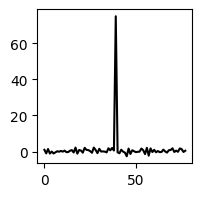

INFO: Loading burst configuration from: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/casey.yaml
INFO: Loading telescope configuration from: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/../telescopes/dsa.yaml
INFO: Configurations successfully loaded and merged.
INFO: Loading DynamicSpectrum from file: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/dsa110-scat/scintillation/scint_analysis/data/casey.npz


--- Loaded Configuration ---
{
  "telescope_name": "DSA-110",
  "instrument_type": "Multi-Dish Interferometer",
  "native_channel_width_mhz": 0.03051757812,
  "total_bandwidth_mhz": 187.5,
  "num_channels": 6144,
  "min_freq_mhz": 1311.25,
  "max_freq_mhz": 1498.75,
  "burst_id": "casey",
  "input_data_path": "/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/dsa110-scat/scintillation/scint_analysis/data/casey.npz",
  "telescope": "dsa",
  "analysis": {
    "rfi_masking": {
      "find_burst_thres": 5.0,
      "use_symmetric_noise_window": true,
      "rfi_downsample_factor": 16,
      "enable_time_domain_flagging": false,
      "time_threshold_sigma": 7.0,
      "freq_threshold_sigma": 5.0
    },
    "acf": {
      "num_subbands": 4,
      "max_lag_mhz": 45.0,
      "use_snr_subbanding": true
    },
    "fitting": {
      "fit_lagrange_mhz": 45.0,
      "reference_frequency_mhz": 1400.0
    }
  },
  "pipeline_options": {
    "log_level": "INFO",
    "save_intermediate_step

INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 2500)
INFO: Generating dynamic spectrum plot.


Raw spectrum loaded successfully.
<DynamicSpectrum (6144 channels x 2500 timesteps, 1311.2-1498.8 MHz)>

Displaying raw dynamic spectrum...


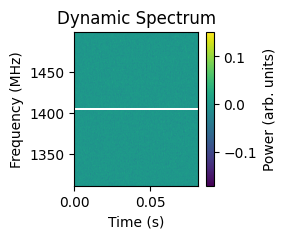

INFO: Applying RFI masking.
INFO: Using time downsampling factor of 16 for RFI statistical checks.
INFO: Finding full signal envelope with S/N threshold > 5.0 (downsample ×8).
INFO: Full signal envelope found between bins 1256 and 1271.
INFO: Using symmetric noise window of duration 15 bins.
INFO: Using downsampled noise statistics from bins 77 to 78.



Applying RFI masking...


Iterative RFI Masking in Frequency Domain: 100%|██████████| 5/5 [00:00<00:00, 694.28it/s]
INFO: Masked 0 channels based on frequency-domain stats.
INFO: Skipping time-domain RFI flagging as per configuration.
INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 2500)
INFO: Generating dynamic spectrum plot.


RFI masking complete.

Displaying RFI-masked dynamic spectrum...


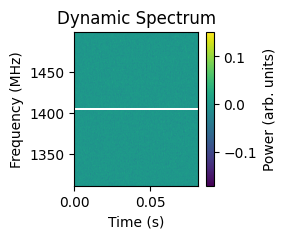

INFO: Starting sub-band ACF calculations.
INFO: Finding full signal envelope with S/N threshold > 5.0 (downsample ×8).
INFO: Full signal envelope found between bins 1256 and 1271.



Calculating ACFs for all sub-bands (this may take a moment)...


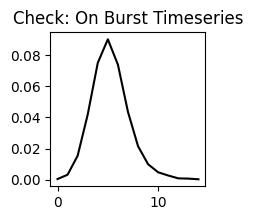

INFO: Using symmetric noise window of duration 15 bins.
Calculating sub-band ACFs: 100%|██████████| 4/4 [00:00<00:00, 44.57it/s]
INFO: Fitting all ACF models to all sub-band ACFs...


ACF calculation complete.

ACF Results Dictionary Keys: dict_keys(['subband_acfs', 'subband_lags_mhz', 'subband_center_freqs_mhz', 'subband_channel_widths_mhz', 'subband_num_channels'])
Computed ACFs for 4 sub-bands.

Fitting models and deriving final scintillation parameters...


INFO: --- Model Comparison (Lowest Total BIC is Best) ---
INFO: Model 'fit_1c_lor': Total BIC = -36581.65 (from 4 fits)
INFO: Model 'fit_2c_lor': Total BIC = -24808.99 (from 3 fits)
INFO: Model 'fit_1c_gauss': Total BIC = -36186.73 (from 4 fits)
INFO: Model 'fit_2c_gauss': Total BIC = -25794.16 (from 3 fits)
INFO: ==> Best overall model selected: fit_1c_lor
INFO: Generating full analysis overview plot.


Analysis complete.

--- Final Derived Parameters ---
{
  "best_model": "fit_1c_lor",
  "components": {
    "scint_scale": {
      "power_law_fit_report": [
        2.010124792228405e-09,
        2.8364871387202912
      ],
      "scaling_index": 2.8364871387202912,
      "scaling_index_err": 19.183037981321714,
      "bw_at_ref_mhz": 1.6872317140451365,
      "bw_at_ref_mhz_err": 0.8493381502928066,
      "subband_measurements": [
        {
          "freq_mhz": 1324.4815236854959,
          "bw": 2.302610996664314,
          "mod": 0.3977613801984734,
          "bw_err": 0.12556720679626796,
          "finite_err": 0.33941468231261723
        },
        {
          "freq_mhz": 1365.2901676705194,
          "bw": 12.721848432969393,
          "mod": 1.140616544032408,
          "bw_err": 0.0768978557125016,
          "finite_err": 3.055808106466236
        },
        {
          "freq_mhz": 1410.829806283575,
          "bw": 1.348577332124393,
          "mod": 0.24526926969015905,
    

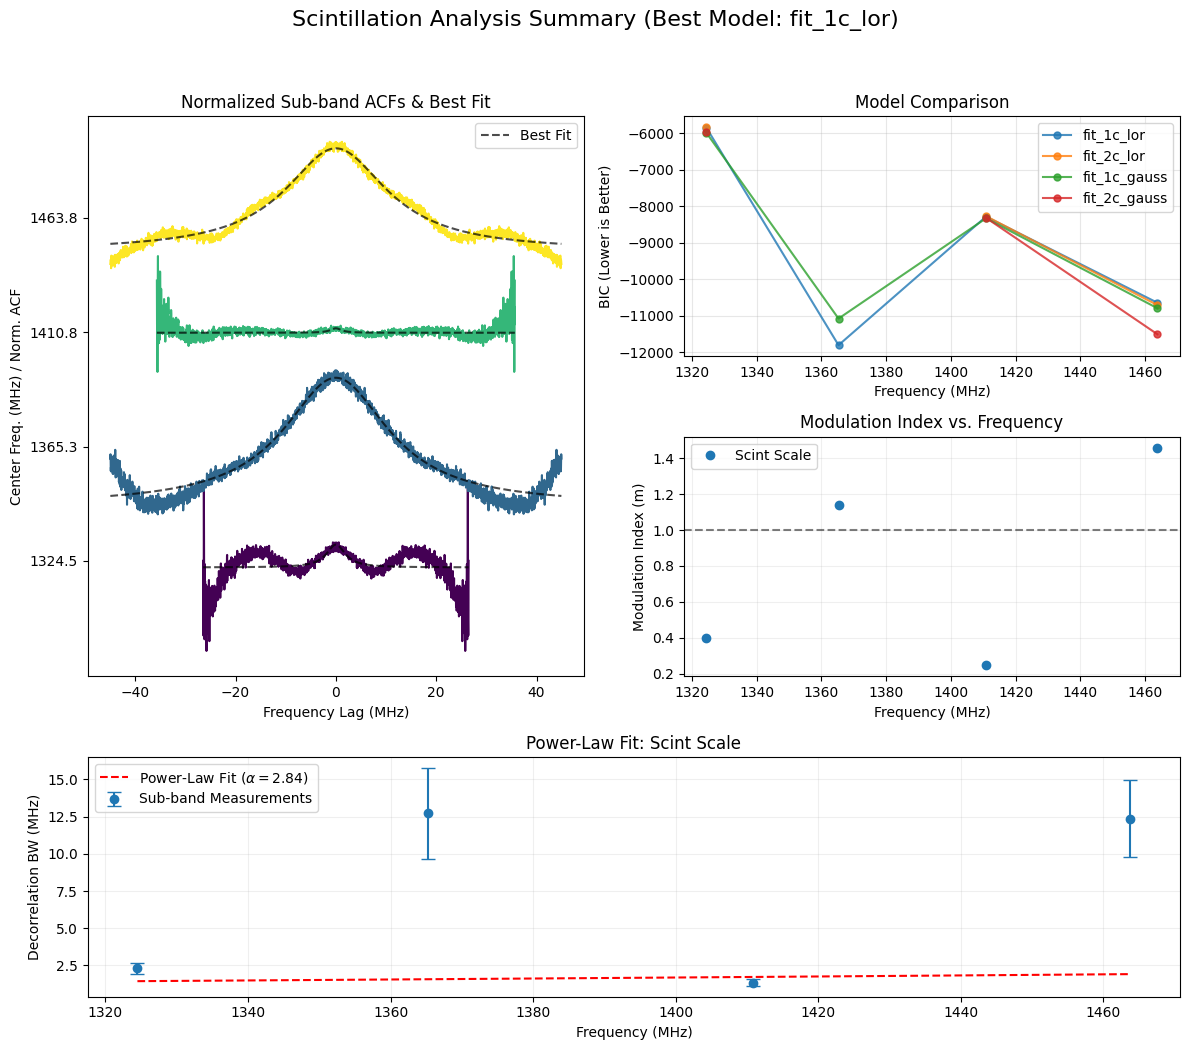

In [6]:
# Set path for module imports
import sys, os
# replace the path below with the absolute path to your `scattering/` folder
pkg_root = "/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation"
sys.path.insert(0, pkg_root)

%load_ext autoreload
%autoreload 2

import logging
import json
import importlib
import numpy as np

import matplotlib.pyplot as plt

# Import all modules from our new package

from scint_analysis import config
from scint_analysis import core
from scint_analysis import analysis
from scint_analysis import plotting

# --- Configuration ---
# Set up basic logging to see pipeline output in the notebook
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Define the path to the configuration file for the analysis run
BURST_CONFIG_PATH = '/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/casey.yaml'

casey = np.load('/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/dsa110-scat/scintillation/scint_analysis/data/casey_dsa_I_491_211_2500b_cntr_bpc.npy')
downsample_factor = 32
prof = np.nansum(casey,axis=0)
n = prof.size - (prof.size % downsample_factor)
prof = prof[:n].reshape(-1, downsample_factor).mean(axis=1)
    
fig = plt.figure(figsize = (2, 2))
plt.plot(prof, c ='k')
plt.show()

# Load the merged configuration from the YAML files
try:
    analysis_config = config.load_config(BURST_CONFIG_PATH)
    # Pretty-print the configuration to verify it
    print("--- Loaded Configuration ---")
    print(json.dumps(analysis_config, indent=2))
except Exception as e:
    logging.error(f"Failed to load configuration: {e}")

# Load the dynamic spectrum from the path specified in the config
try:
    raw_spectrum = core.DynamicSpectrum.from_numpy_file(analysis_config['input_data_path'])
    print("Raw spectrum loaded successfully.")
    print(raw_spectrum)
except Exception as e:
    logging.error(f"Failed to load data: {e}")

# --- Visualization Step 1: Inspect Raw Data ---
if 'raw_spectrum' in locals():
    print("\nDisplaying raw dynamic spectrum...")
    plotting.plot_dynamic_spectrum(raw_spectrum, figsize=(2, 2))

# --- Perform RFI Masking ---
if 'raw_spectrum' in locals():
    print("\nApplying RFI masking...")
    masked_spectrum = raw_spectrum.mask_rfi(analysis_config)
    print("RFI masking complete.")

    # --- Visualization Step 2: Inspect Masked Data ---
    print("\nDisplaying RFI-masked dynamic spectrum...")
    plotting.plot_dynamic_spectrum(masked_spectrum, figsize=(2, 2))

# --- Calculate ACFs for all sub-bands ---
if 'masked_spectrum' in locals():
    print("\nCalculating ACFs for all sub-bands (this may take a moment)...")
    acf_results = analysis.calculate_acfs_for_subbands(masked_spectrum, analysis_config)
    print("ACF calculation complete.")
    
    # You can inspect the structure of the results
    print("\nACF Results Dictionary Keys:", acf_results.keys())
    print(f"Computed ACFs for {len(acf_results['subband_acfs'])} sub-bands.")
    
# --- Run the final analysis and fitting stage ---
if 'acf_results' in locals() and acf_results['subband_acfs']:
    print("\nFitting models and deriving final scintillation parameters...")
    # This function returns both the final parameters and the raw lmfit objects
    final_results, all_subband_fits, powlaw_fit_params = analysis.analyze_scintillation_from_acfs(acf_results, analysis_config)
    print("Analysis complete.")

    # --- Inspect the Final Results ---
    print("\n--- Final Derived Parameters ---")
    print(json.dumps(final_results, indent=2))
else:
    logging.error("ACF results not available. Cannot proceed to final analysis.")
    
# --- Generate the final overview plot ---
if 'final_results' in locals() and 'all_subband_fits' in locals():
    print("\nGenerating final analysis overview plot...")
    plotting.plot_analysis_overview(
        filename='../casey_dsa_scint.pdf',
        analysis_results=final_results,
        acf_results=acf_results,
        all_subband_fits=all_subband_fits,
        powlaw_fit_params=powlaw_fit_params
    )
else:
    logging.warning("Final results not available, skipping overview plot.")


In [6]:
# Import all modules from our new package
import scint_analysis
importlib.reload(scint_analysis)
from scint_analysis import config, core, analysis, plotting

# --- Run the final analysis and fitting stage ---
if 'acf_results' in locals() and acf_results['subband_acfs']:
    print("\nFitting models and deriving final scintillation parameters...")
    # This function returns both the final parameters and the raw lmfit objects
    final_results, all_subband_fits, powlaw_fit_params = analysis.analyze_scintillation_from_acfs(acf_results, analysis_config)
    print("Analysis complete.")

    # --- Inspect the Final Results ---
    print("\n--- Final Derived Parameters ---")
    print(json.dumps(final_results, indent=2))
else:
    logging.error("ACF results not available. Cannot proceed to final analysis.")


INFO: Fitting Lorentzian models to all sub-band ACFs...
/opt/pysetup/.venv/lib/python3.8/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")



Fitting models and deriving final scintillation parameters...


INFO: Model selection complete. Best overall model: 1 component(s).


Analysis complete.

--- Final Derived Parameters ---
{
  "best_model": 1,
  "components": {
    "scint_scale": {
      "power_law_fit_report": [
        2.010124792228405e-09,
        2.8364871387202912
      ],
      "scaling_index": 2.8364871387202912,
      "scaling_index_err": 19.183037981321714,
      "bw_at_ref_mhz": 1.6872317140451365,
      "bw_at_ref_mhz_err": 0.8493381502928066,
      "subband_measurements": [
        {
          "freq_mhz": 1324.4815236854959,
          "bw": 2.302610996664314,
          "mod": 0.3977613801984734,
          "bw_err": 0.12556720679626796,
          "finite_err": 0.33941468231261723
        },
        {
          "freq_mhz": 1365.2901676705194,
          "bw": 12.721848432969393,
          "mod": 1.140616544032408,
          "bw_err": 0.0768978557125016,
          "finite_err": 3.055808106466236
        },
        {
          "freq_mhz": 1410.829806283575,
          "bw": 1.348577332124393,
          "mod": 0.24526926969015905,
          "bw_e